In [1]:
pip install --upgrade plotly

     |████████████████████████████████| 13.2MB 287kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [4]:
pip install catboost

In [154]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
from catboost import CatBoostRegressor
from ipywidgets import widgets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from plotly.subplots import make_subplots
import datetime as dt
pd.options.display.max_colwidth = 150

# Шаг 1. Загрузим данные и посмотрим датасет


In [155]:
# Загрузим дата сет и посмотрим первые три строки
air = pd.read_csv('/content/AB_NYC_2019.csv')
air.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [156]:
# Проверим пустые значения в файлах
def missing_values(df):
    total = df.isna().sum()
    percentage = round(total/df.shape[0]*100,2)
    return pd.concat([total,percentage],axis = 1, keys = ['total','percentage'])

# Проверим дублирующиеся значения в файлах
def duplicates_values(df):
    dup = []
    columns = df.columns
    for row in df.columns:
        dup.append(df.duplicated().sum())
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis = 1, keys = ['columns','duplicate count'])

# Посмотрим общую информацию о файлах
def df_info(df):
    df.info()
    display(df.describe())
    display(df.head(5))
    display(df.shape)

In [157]:
missing_values(air)

,total,percentage
id,0,0.00
name,16,0.03
host_id,0,0.00
host_name,21,0.04
neighbourhood_group,0,0.00
neighbourhood,0,0.00
latitude,0,0.00
longitude,0,0.00
room_type,0,0.00
price,0,0.00


In [158]:
duplicates_values(air)

,columns,duplicate count
0,id,0
1,name,0
2,host_id,0
3,host_name,0
4,neighbourhood_group,0
5,neighbourhood,0
6,latitude,0
7,longitude,0
8,room_type,0
9,price,0


In [159]:
df_info(air)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


(48895, 16)

****
## Вывод:

*   данные загружены(размер 48895 строк и 16 колонок)
*   в датасете есть пустые значения в столбцах (name,last_review,reviews_per_month,host_name)
*   дублирующихся значений нет
****




  




****
# Шаг 2. Сделаем предобработку данных

*   Заменим пустые значения в колонке name на unknown
*   Заменим пустые значения в колонке host_name на unknown
*   Колонки last_review и reviews_per_month удалим, так как если эти кваритры(комнаты никто не смотрит , то и смысла в них особого нет)
*   Заменим тип данных в колонке last_review на date.
*   Так же в датасете есть выбросы в колонках «price» и «minimum nights», 10000$ и 1250 nights



In [160]:
# Заменим пустые значения в колонке name
air['name'] = air['name'].replace(np.NaN,'unknown')

In [161]:
# Заменим пустые значения в колонке host_name
air['host_name'] = air['host_name'].replace(np.NaN,'unknown')

In [162]:
df = air.dropna()

In [163]:
df['price'].quantile(0.99)

671.1600000000035

In [164]:
df['minimum_nights'].quantile(0.99)

31.0

In [165]:
# Сделаем срез , что бы убрать выбросы (по колонкам price и minimum_nights)
df = df.query('price <= 671.16 and minimum_nights <= 31')

In [166]:
# Поменяем тип данных в колонке last_review на date
df['last_review'] =df['last_review'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [167]:
print('Количество потерянных данных =',\
      round(100-len(df)/len(air)*100, 2),'%')

Количество потерянных данных = 21.95 %


***
### Вывод 

1.   Заменили пустые значения в колонках «host_name» и «name»
2.   Сделал срез по данным, взял значение из колонки «price» == 671.1$ так как 99% значений лежат в этом диапозоне. Взял значение из колоки «minimum_nights» == 31, так как 99% значений лежат именно в этом диапозоне
3.  В процессе предобработки мы потеряли 21.95 % от первоночального датасета
****



******

# Шаг 3. EDA анализ

1.   В датасете есть координаты всех объектов, я хочу получить дистанцию каждого объекта до центра, центрального парка и Эмпайр-стейт-билдинг, это понадобится для дальнейшего ML
2.   Визуализируем данные( построим гисторамму, sunburst и отрисуем карту со всеми объектами)



### 3.1 Получим дистанцию

In [168]:
# сделаем кортеж из колонки долготы и широты
df['lat_long'] = df[['latitude','longitude']].apply(tuple, axis=1)

In [169]:
# координаты Нью-Йорка
new_york = (40.714599, -74.002791)

In [170]:
# координаты центрального парка
center_park = (40.7825, -73.965493)

In [171]:
# координаты Эмпайр-стейт-билдинг
empire_state_building = (40.748391, -73.985543)

In [172]:
# координаты Таймс сквер
times_square = (40.755878, -73.986729)

In [173]:
# посчитаем дистанцию
from geopy import distance

distance_to_times_square = []
distance_to_empire_state_building = []
distance_to_center_park = []
distance_to_center = []


for i in df['lat_long']:
  distance_1 = (distance.distance(i, new_york).km)
  distance_2 = (distance.distance(i, center_park).km)
  distance_3 = (distance.distance(i, empire_state_building).km)
  distance_4 = (distance.distance(i, times_square).km)


  distance_to_center.append(distance_1)
  distance_to_center_park.append(distance_2)
  distance_to_empire_state_building.append(distance_3)
  distance_to_times_square.append(distance_4)


df['distance_to_center']=distance_to_center
df['distance_to_center_park']=distance_to_center_park
df['distance_to_empire_state_building']=distance_to_empire_state_building
df['distance_to_times_square']=distance_to_times_square

In [174]:
df.sample(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,lat_long,distance_to_center,distance_to_center_park,distance_to_empire_state_building,distance_to_times_square
12820,9786398,LOCATION! Private room with yard.,1698487,Chelsea,Brooklyn,Prospect Heights,40.67835,-73.96846,Private room,85,1,90,2019-06-16,2.08,1,345,"(40.67835, -73.96846)",4.962186,11.568438,7.910752,8.746651
9631,7398507,Chic apartment on Central Park West,5898139,Nicholas,Manhattan,Upper West Side,40.79933,-73.95949,Entire home/apt,185,1,1,2015-09-02,0.02,1,0,"(40.79933, -73.95949)",10.094802,1.936426,6.069302,5.345206


***

### 3.2 Отрисуем гистограмму (по удалению обьектов от центра)

In [175]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [176]:
x = df.query('room_type == "Private room"')['distance_to_center']
y = df.query('room_type == "Entire home/apt"')['distance_to_center']
z = df.query('room_type == "Shared room"')['distance_to_center']

fig = go.Figure()

fig.add_trace(go.Histogram(x=x,name="Private room",marker_color='green', opacity=0.8))
fig.add_trace(go.Histogram(x=y,name="Entire home/apt",marker_color='blue',opacity=0.7))
fig.add_trace(go.Histogram(x=z,name="Shared room",marker_color='red'))

fig.update_layout(barmode='overlay')

fig.update_layout(
    title_text='Количество здаваемых обьектов по удалению от центра',
    xaxis_title_text='distance to center',
    yaxis_title_text='count',
    bargap=0.2,
    bargroupgap=0.1
)

fig.show()

### Вывод:

1.   Для Private room - количество сдаваемых объектов возрастает до 5 км, потом начинает снижаться
2.   Для Entire home/apt - возрастает до 5-6 км, потом начинает постепено снижаться
3.   Для Shared room - самое большое количестов объектов находиться на расстоянии 5-6 км и 8-9 км



****
### 3.3 Отрисуем sunburst
****

In [177]:
sunburst=df.groupby(['neighbourhood_group','neighbourhood']).agg(count = ('room_type','count'),
                                                         median_price = ('price','median'),
                                                         max_price = ('price','max'),
                                                         min_price = ('price','min')).reset_index()
sunburst.sample(3)                                                        

,neighbourhood_group,neighbourhood,count,median_price,max_price,min_price
189,Staten Island,Grant City,4,66.0,80,30
145,Queens,Flushing,363,63.0,500,20
216,Staten Island,Westerleigh,2,71.5,103,40


In [178]:
fig = px.sunburst(sunburst, path=['neighbourhood_group', 'neighbourhood'],
                  values='median_price',color='median_price',color_continuous_scale='RdBu',)
fig.update_layout(
    margin = dict(t=0, l=0, r=100, b=10)
)
fig.show()

In [179]:
df.groupby(['neighbourhood_group']).\
agg(count = ('room_type','count'),
    median_price = ('price','median'),
    max_price = ('price','max'),
    min_price = ('price','min')).reset_index()


,neighbourhood_group,count,median_price,max_price,min_price
0,Bronx,867,64,670,0
1,Brooklyn,16266,92,659,0
2,Manhattan,16174,140,655,10
3,Queens,4541,72,600,10
4,Staten Island,313,75,625,13


*****
### Вывод

1.  Больше всего жилья сдается в районе Бруклина и Манхеттена, 16266 и 16174 сответственно
2.  Самая высокая цена по медиане в районе Манхеттен 140 $
3.  По макc.цене все районы примерно находятся в одной ценовой категории
4.  На графике sunburst можно посмотреть самые дорогие и районы  по мед.цене

*****


****
### 3.4 Отрисуем карту с местоположением всех объектов в Нью-Йорке
****

In [180]:
fig = px.scatter_mapbox(df, lat='latitude', 
                        lon='longitude', 
                        hover_name='room_type',color = 'price',
                        zoom=9, height=800, width=1000,size_max=10, )
fig.update_layout(
    mapbox_style="open-street-map" )#"open-street-map", "carto-positron", "carto-darkmatter", "stamen-terrain", "stamen-toner" or "stamen-watercolor" 
fig.show()

### Вывод

*   Как можно увидеть на отрисованной карте самое большое количество объектов с высокой ценой расположенно в районе Манхеттана




# 4 Применим ML для прогноза цены ( буду использовать catboost)

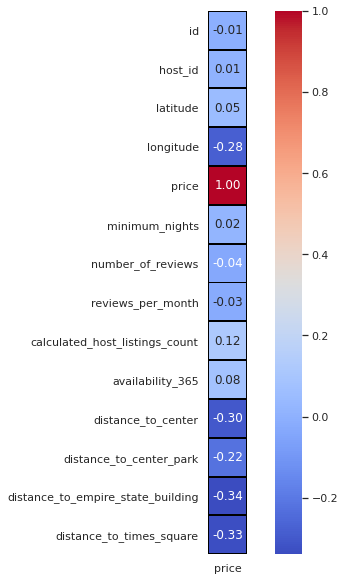

In [181]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.heatmap(df.corr()[['price']], 
            annot = True,
            square=True,
            fmt='.2f',
            cmap= 'coolwarm',
            linewidths=1, 
            linecolor='black')
plt.show()

In [182]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'lat_long', 'distance_to_center',
       'distance_to_center_park', 'distance_to_empire_state_building',
       'distance_to_times_square'],
      dtype='object')

In [183]:
features = [x for x in df.columns if x not in ['price']]
X = df[features]
y = df['price']

In [184]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=1)

numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]

categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() <= 20  and 
                    X_train[cname].dtype == "object"]


numerical_transformer = SimpleImputer(strategy='mean')

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols )
])
 

CatBoost = CatBoostRegressor(verbose=5000,random_state=42,iterations=10000)

random_clf = Pipeline(steps=[('preprocessor', preprocessor),
                             ('CatBoost', CatBoost)])

random_clf.fit(X_train, y_train)


random_preds = random_clf.predict(X_valid)

Learning rate set to 0.012322
0:	learn: 91.4191574	total: 9.96ms	remaining: 1m 39s
5000:	learn: 55.6483252	total: 42.1s	remaining: 42s
9999:	learn: 50.0780750	total: 1m 25s	remaining: 0us


In [185]:
print('---------------------------------------')
print('MAE: {:.2f}'.format(mean_absolute_error(y_valid, random_preds)))
print('---------------------------------------')
print('MSE: {:.2f}'.format(mean_squared_error(y_valid, random_preds)))
print('---------------------------------------')
print('R2: {:.2f}'.format(r2_score(y_valid, random_preds)))
print('---------------------------------------')

---------------------------------------
MAE: 39.52
---------------------------------------
MSE: 3892.31
---------------------------------------
R2: 0.52
---------------------------------------


In [186]:
df['predict_price'] = random_clf.predict(X)

In [187]:
df['error'] = np.abs(df['price'] - df['predict_price'])

In [188]:
print('---------------------------------')
print('Средняя ошибка:',round(df['error'].mean(),2),"$")
print('---------------------------------')
print('Медиана ошибки:',round(df['error'].median(),2),"$")
print('---------------------------------')
print('Медина ошибки для категории жилья Private room =', round(df.query('room_type == "Private room"')['error'].median(),2), "$")
print('---------------------------------')
print('Медина ошибки для категории жилья Entire home/apt =', round(df.query('room_type == "Entire home/apt"')['error'].median(),2), "$")
print('---------------------------------')
print('Медина ошибки для категории жилья Shared room =', round(df.query('room_type == "Shared room"')['error'].median(),2), "$")
print('---------------------------------')

---------------------------------
Средняя ошибка: 34.19 $
---------------------------------
Медиана ошибки: 21.5 $
---------------------------------
Медина ошибки для категории жилья Private room = 14.0 $
---------------------------------
Медина ошибки для категории жилья Entire home/apt = 34.96 $
---------------------------------
Медина ошибки для категории жилья Shared room = 10.66 $
---------------------------------


# Вывод:

***Модель показывает следующие результаты***


MAE: 39.52
---------------------------------------
MSE: 3892.31
---------------------------------------
R2: 0.52
---------------------------------------

Средняя ошибка: 34.19 
---------------------------------
Медиана ошибки: 21.5 
---------------------------------
Медина ошибки для категории жилья Private room = 14.0
---------------------------------
Медина ошибки для категории жилья Entire home/apt = 34.96
---------------------------------
Медина ошибки для категории жилья Shared room = 10.66
---------------------------------


